In [260]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time
from matplotlib import pyplot as plt
import os
import numpy as np
import random
#https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844
import torch.optim as optim

In [261]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything()

Files already downloaded and verified
CIFAR10 data shape: (50000, 32, 32, 3)
CIFAR10 targets shape: 50000


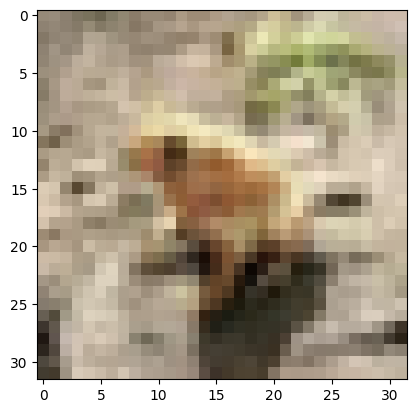

6


In [262]:
# 데이터 로드
# CIFAR10 datset: 32 * 32 * 3 사이즈의 이미지들을 가진 dataset
cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

# shape 및 실제 데이터 확인
print('CIFAR10 data shape:', cifar.data.shape)
print('CIFAR10 targets shape:', len(cifar.targets))

num = 6000
plt.imshow(cifar.data[num])
plt.show()
print(cifar.targets[num])

In [263]:
# Device configuration, gpu 사용 가능한 경우 device를 gpu로 설정하고 사용 불가능하면 cpu로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [326]:
# Hyper-parameters
num_epochs = 30
batch_size = 300
learning_rate = 0.001

#drop_prob = 0.5 # dropout
#weight_decay_lambda = 0 # weight_decay

In [327]:
# 파이토치에서 제공하는 CIFAR10 dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./data',train=True, transform=transforms.ToTensor(), download=True)

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [40000, 10000]) # 5만개의 데이터를 40000, 10000개로 나눈다.

# data 개수 확인
print('The number of training data : ', len(train_dataset))
print('The number of validation data : ', len(val_dataset))

Files already downloaded and verified
The number of training data :  40000
The number of validation data :  10000


In [328]:
# 배치 단위로 네트워크에 데이터를 넘겨주는 Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=False)

In [340]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
    self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
    self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
    self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)
  
    self.pool1 = nn.MaxPool2d(2, 2) 

    self.fc1 = nn.Linear(4096,1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 128)
    self.fc4 = nn.Linear(128, 10)
    

    self.dropout1 = nn.Dropout(p=0.2)

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)

    self.bn_1 = nn.BatchNorm1d(512)
    self.bn_2 = nn.BatchNorm1d(128)

  def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))
      
      x = F.relu(self.conv2(x))
      x = self.pool1(x)
      x = self.dropout1(x)
      x = F.relu(self.bn2(self.conv3(x)))
      x = self.dropout1(x)
      x = F.relu(self.conv4(x))
      x = self.pool1(x)
      x = self.dropout1(x)

      x = F.relu(self.bn3(self.conv5(x)))
      x = self.dropout1(x)   
      x = F.relu(self.conv6(x))
      x = self.pool1(x)   
      x = self.dropout1(x)   
      
      x = x.view(x.size(0), -1)

      x = self.dropout1(x)  
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)   
      x = F.relu(self.bn_1(self.fc2(x)))
      x = self.dropout1(x)   
      x = F.relu(self.bn_2(self.fc3(x)))  
      x = self.dropout1(x)  
      x = self.fc4(x)

      return x

net = CNN().to(device) # 모델 선언  

In [341]:
model = CNN().to(device)  # 모델을 지정한 device로 올려줌

In [342]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [343]:
# training 시작
folder_path = './saved_model/setting_1/' # weight 저장할 폴더 설정
writer = SummaryWriter(folder_path + 'logs/') # TensorBoard를 위한 초기화
start_time = time.time()
highest_val_acc = 0
val_acc_list = []
print('========================================')
print("Start training")
global_step = 0
for epoch in range(num_epochs):
    train_correct_cnt = 0
    train_loss = 0
    train_batch_cnt = 0
    model.train() # training 모드
    for img, label in train_loader:
        # img.shape: [300, 3, 32, 32]
        # label.shape: [300]
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad() # iteration 마다 gradient를 0으로 초기화
        pred = model.forward(img)
        #pred = model.forward(img.view(32* 32* 3)) # 32 * 32 * 3 3채널 이미지를 1024 features로 reshape 후 forward
        loss = criterion(pred, label) # cross entropy loss 계산
        loss.backward() # 가중치 w에 대해 loss를 미분
        optimizer.step() # 가중치들을 업데이트
        train_loss += loss.item()
        train_batch_cnt += 1
        _, top_pred = torch.topk(pred, k=1, dim=-1)
        top_pred = top_pred.squeeze(dim=1)

        
        batch_total = label.size(0)
        batch_correct = int(torch.sum(top_pred == label))
        batch_acc = batch_correct / batch_total
        writer.add_scalar("Batch/Loss", loss.item(), global_step)
        writer.add_scalar("Batch/Acc", batch_acc, global_step)

        if (global_step) % 100 == 0:
            print('Epoch [{}/{}], Step [{}], Loss: {:.4f}'.format(epoch+1, num_epochs, global_step, loss.item()))

        train_correct_cnt += int(torch.sum(top_pred == label)) # 맞춘 개수 카운트

        global_step += 1

    train_acc = train_correct_cnt / len(train_dataset) * 100
    train_ave_loss = train_loss / train_batch_cnt # 학습 데이터의 평균 loss
    writer.add_scalar("Train/Loss", train_ave_loss, epoch)
    writer.add_scalar("Train/Acc", train_acc, epoch)
    training_time = (time.time() - start_time) / 60
    print('========================================')
    print("epoch:", epoch + 1)
    print("training dataset average loss : %.3f" % train_ave_loss)
    print("training_time : %.2f minutes" % training_time)
    print('========================================')

    # validation (for early stopping)
    val_correct_cnt = 0
    val_loss = 0
    val_batch_cnt = 0
    model.eval() # evaluation 모드
    for img, label in val_loader:
        img = img.to(device)
        label = label.to(device)
        pred = model.forward(img)
        loss = criterion(pred, label)
        val_loss += loss.item()
        val_batch_cnt += 1
        _, top_pred = torch.topk(pred, k=1, dim=-1)
        top_pred = top_pred.squeeze(dim=1)
        val_correct_cnt += int(torch.sum(top_pred == label)) # 맞춘 개수 카운트

    val_acc = val_correct_cnt / len(val_dataset) * 100 # validation accuracy 계산
    val_ave_loss = val_loss / val_batch_cnt # 학습 데이터의 평균 loss
    print("validation dataset accuracy : %.3f" % val_acc)
    val_acc_list.append(val_acc)
    writer.add_scalar("Val/Loss", val_ave_loss, epoch)
    writer.add_scalar("Val/Acc", val_acc, epoch)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    save_path = folder_path + 'epoch_' + str(epoch + 1) + '.pth'
    torch.save({'epoch': epoch + 1,
                'model_state_dict': model.state_dict()},
               save_path)

    if val_acc > highest_val_acc: # validation accuracy가 경신될 때
        save_path = folder_path + 'best.pth'
        torch.save({'epoch': epoch + 1,
                    'model_state_dict': model.state_dict()},
                   save_path) # best accuracy에 도달할 때 'best.pth'로 모델을 저장함으로써 early stopping
        highest_val_acc = val_acc

print("Training finished.")
# 각 epoch에서의 accuracy를 시각화
writer.close()

Start training
Epoch [1/30], Step [0], Loss: 2.4054
Epoch [1/30], Step [100], Loss: 1.3567
epoch: 1
training dataset average loss : 1.594
training_time : 0.23 minutes
validation dataset accuracy : 54.630
Epoch [2/30], Step [200], Loss: 1.0665
epoch: 2
training dataset average loss : 1.096
training_time : 0.50 minutes
validation dataset accuracy : 60.510
Epoch [3/30], Step [300], Loss: 0.8773
Epoch [3/30], Step [400], Loss: 0.7848
epoch: 3
training dataset average loss : 0.867
training_time : 0.77 minutes
validation dataset accuracy : 70.700
Epoch [4/30], Step [500], Loss: 0.6799
epoch: 4
training dataset average loss : 0.736
training_time : 1.04 minutes
validation dataset accuracy : 66.100
Epoch [5/30], Step [600], Loss: 0.5523
epoch: 5
training dataset average loss : 0.645
training_time : 1.31 minutes
validation dataset accuracy : 76.990
Epoch [6/30], Step [700], Loss: 0.5724
Epoch [6/30], Step [800], Loss: 0.6515
epoch: 6
training dataset average loss : 0.580
training_time : 1.57 min

In [ ]:
# Tensorboard를 활용하여 Loss와 Accuracy 변화 확인
%load_ext tensorboard
%tensorboard --logdir {'./saved_model/'}

In [344]:
# 모델의 Test

# 모델 생성
model = CNN().to(device)

model.eval()

# 데이터 로드
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())

# data 개수 확인
print('The number of test data : ', len(test_dataset))

# 배치 생성
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 저장된 state 불러오기
save_path = "./saved_model/setting_1/best.pth" # 불러올 모델의 checkpoint 위치
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
correct_cnt = 0
for img, label in test_loader:
    img = img.to(device)
    label = label.to(device)
    pred = model.forward(img)
    _, top_pred = torch.topk(pred, k=1, dim=-1)
    top_pred = top_pred.squeeze(dim=1)

    correct_cnt += int(torch.sum(top_pred == label))

accuracy = correct_cnt / len(test_dataset) * 100
print("accuracy of the trained model : %.2f%%" % accuracy)


The number of test data :  10000
accuracy of the trained model : 85.56%
